### Dependencies and Helper Methods

In [460]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [453]:

# inspired by https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

### Load Images

In [454]:
images = load_images_from_folder("images")

#### Show First Image

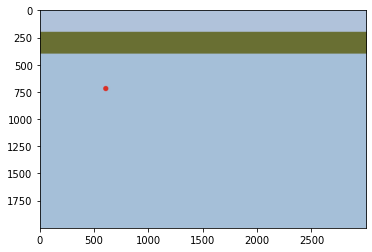

In [461]:
# convert from BGR (cv2) to RGB (matplotlib)
first_img = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)

# show image
plt.figure()
plt.imshow(first_img) 
plt.show()

### Determine Buoy Color and Locate Treeline (Pixels)

#### Buoy Color

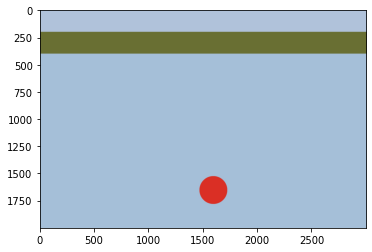

In [456]:
# use image with large buoy (image1 works)
img1 = cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img1) 
plt.show()

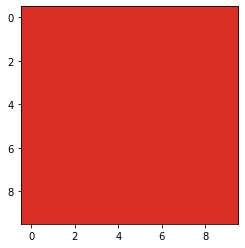

In [181]:
# buoy appears to exist at pixel (1750, 600)
BUOY_COLOR = images[1][1750][1600]

# confirm that colors match
color_test = np.zeros((10,10,3), np.uint8)
color_test[:] = BUOY_COLOR
color_test = cv2.cvtColor(color_test, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(color_test) 
plt.show()

#### Treeline

In [182]:
TREE_COLOR = images[1][250][0]
SKY_COLOR = images[1][0][0]
WATER_COLOR = images[1][500][0]
first_img = images[0]
img_height = first_img.shape[1]

top = 0
for row in range(img_height):
    if((first_img[row][0] == TREE_COLOR).all()):
        top = row
        break

bottom = 0
for row in range(top, img_height):
    if((first_img[row][0] == WATER_COLOR).all()):
        bottom = row - 1
        break

TREELINE_TOP = top
TREELINE_BOTTOM = bottom
print("Top", TREELINE_TOP)
print("Bottom", TREELINE_BOTTOM)

Top 209
Bottom 400


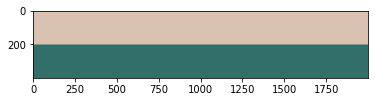

In [183]:
section_img = images[1][0:TREELINE_BOTTOM, 0:images[0].shape[0]]
plt.figure()
plt.imshow(section_img) 
plt.show()

### Identify Buoy Location and Size

In [434]:
def get_dist(x_coords, y_coords):
    return ((x_coords[1] - x_coords[0])**2 + (y_coords[1] - y_coords[0])**2)**(1/2)

def identify_buoy(img):
    img_height = img.shape[0]
    img_width = img.shape[1]

    # get all indices where pixels are color of buoy (buffer of 20 for RBG vals)
    buoy_indices = np.array(np.where(np.all(img < BUOY_COLOR+20, axis=2) & np.all(img > BUOY_COLOR-20, axis=2))).T

    # if buoy in trees or sky, or no buoy at all, return -1
    if((buoy_indices[:, 0] < TREELINE_BOTTOM).any() or (buoy_indices.size == 0)): return -1

    # get extremes of buoy pixels
    max_row = np.max(buoy_indices[:, 0])
    min_row = np.min(buoy_indices[:, 0])
    max_col = np.max(buoy_indices[:, 1])
    min_col = np.min(buoy_indices[:, 1])

    # set default return values for error catching
    x_center = -1
    y_center = -1
    mean_radius = -1

    # if buoy fully visible
    if(min_col > 0 and max_col < img_width and max_row < img_height):
        x_center = (min_col + max_col)//2
        y_center = (min_row + max_row)//2

        # calculate radius as mean of vertical and horizontal radii (in case some weird rounding/conversion error from jpeg to cv2)
        x_radius = (max_col-min_col)//2
        y_radius = (max_row-min_row)//2
        mean_radius = round(np.mean([x_radius, y_radius]))

    # if buoy intersects with left edge of frame
    elif(min_col == 0):

        # if diameter fully visible
        minrowleft = np.min(buoy_indices[buoy_indices[:, 1] == 0][:, 0])
        if(minrowleft > min_row):
            mean_radius = (max_row - min_row) // 2
            x_center = max_col - mean_radius
            y_center = max_row - mean_radius

        # if buoy also intersects with bottom of frame (not used in this dataset and therefore as of yet untested)
        elif(max_row == img_height):
            # get radius via intersecting chords thrm (https://math.stackexchange.com/questions/564058/calculate-the-radius-of-a-circle-given-the-chord-length-and-height-of-a-segment)
            l = get_dist([max_col, min_col], [max_row, min_row])
            
            # get line perpendicular to chord with potential points on circumference of circle
            x_intersect = round(np.mean([min_col, max_col]))
            y_intersect = round(np.mean([min_row, max_row]))
            m = (max_row - min_row)/(max_col - min_col)
            b = y_intersect - m*x_intersect
            x_vals = np.arange(x_intersect, x_intersect+l)
            y_vals = x_vals*m + b
            line = np.array(x_vals, y_vals)

            # find outermost point on circle that is on line perpendicular to chord
            x_matches = np.in1d(line[:,0],buoy_indices[:,0])
            y_matches = np.in1d(line[:,1],buoy_indices[:,1])
            matches = x_matches & y_matches
            outer_point = buoy_indices[np.where(matches)[0][-1]]

            h = get_dist([outer_point[0], x_intersect], [outer_point[1], y_intersect])

            mean_radius = (4*h*h + l*l) // (8*h)
            y_center = round(np.mean([min_row, max_row]))
            x_center = max_col - mean_radius

        else:
            # get radius via intersecting chords thrm (https://math.stackexchange.com/questions/564058/calculate-the-radius-of-a-circle-given-the-chord-length-and-height-of-a-segment)
            l = max_row - min_row
            h = max_col - min_col
            mean_radius = (4*h*h + l*l) // (8*h)
            y_center = round(np.mean([min_row, max_row]))
            x_center = max_col - mean_radius
    
    # if buoy intersects with right edge of frame
    else:

        # if diameter fully visible
        minrowright = np.min(buoy_indices[buoy_indices[:,1] == img_width][:, 0])
        if(minrowright > min_row):
            mean_radius = (max_row - min_row) // 2
            x_center = min_col + mean_radius
            y_center = (max_row - min_row) // 2

        # if buoy also intersects with bottom of frame (not used in this dataset and therefore as of yet untested)
        if(max_row == img_height):
            # get radius via intersecting chords thrm (https://math.stackexchange.com/questions/564058/calculate-the-radius-of-a-circle-given-the-chord-length-and-height-of-a-segment)
            l = get_dist([max_col, min_col], [max_row, min_row])
            
            # get line perpendicular to chord with potential points on circumference of circle
            x_intersect = round(np.mean([min_col, max_col]))
            y_intersect = round(np.mean([min_row, max_row]))
            m = (max_row - min_row)/(max_col - min_col)
            b = y_intersect - m*x_intersect
            x_vals = np.arange(x_intersect, x_intersect+l)
            y_vals = x_vals*m + b
            line = np.array(x_vals, y_vals)

            # find outermost point on circle that is on line perpendicular to chord
            x_matches = np.in1d(line[:,0],buoy_indices[:,0])
            y_matches = np.in1d(line[:,1],buoy_indices[:,1])
            matches = x_matches & y_matches
            outer_point = buoy_indices[np.where(matches)[0][-1]]

            h = get_dist([outer_point[0], x_intersect], [outer_point[1], y_intersect])

            mean_radius = (4*h*h + l*l) // (8*h)
            y_center = round(np.mean([min_row, max_row]))
            x_center = max_col - mean_radius
        else:
            # get radius via intersecting chords thrm (https://math.stackexchange.com/questions/564058/calculate-the-radius-of-a-circle-given-the-chord-length-and-height-of-a-segment)
            l = max_row - min_row
            h = max_col - min_col
            mean_radius = (4*h*h + l*l) // (8*h)
            y_center = round(np.mean([min_row, max_row]))
            x_center = min_col + mean_radius

    return (x_center, y_center, mean_radius)

In [435]:
out = [0]*len(images)
for i, image in enumerate(images):
    out[i] = identify_buoy(image)

### Convert Pixel Data to Real World Distances

Assumptions
- iPhone 12 has pixel size 1.4µm, focal length 26mm
- Images as dimensions 3000x2000
- Therefore, sensor height is 2000*1.4µm = 2.8mm
- 55gal drum has height 865mm

Formula from https://photo.stackexchange.com/questions/12434/how-do-i-calculate-the-distance-of-an-object-in-a-photo <br>
**I clearly have no idea how to properly use LaTeX, apologies for ugly variable name formatting**
#### Formula to Get Distance
$$
Distance to object (mm) = \frac{focal length (mm) * real height (mm) * image height (pixels)}{object height (pixels) * sensor height (mm)}
\newline
$$
$$
= \frac{26 * 865 * 2000}{object height (pixels) * 2.8}
$$

In [479]:
def get_real_world_distance(object_height, focal_length=26, real_height=865, image_height=2000, sensor_height=2.8):
    return (focal_length*real_height*image_height)/(object_height*sensor_height)

buoy_distances_in_meters = [0]*len(out)
for i, datum in enumerate(out):
    if(datum == -1):
        buoy_distances_in_meters[i] = -1
    else:
        buoy_distances_in_meters[i] = round(get_real_world_distance(out[i][2] * 2) / 1000, 2)

### Display Results

Note-- It seems like using the iPhone camera specs didn't line up too well with my simulated set-- intuitively, the buoys are closer than my code finds here.

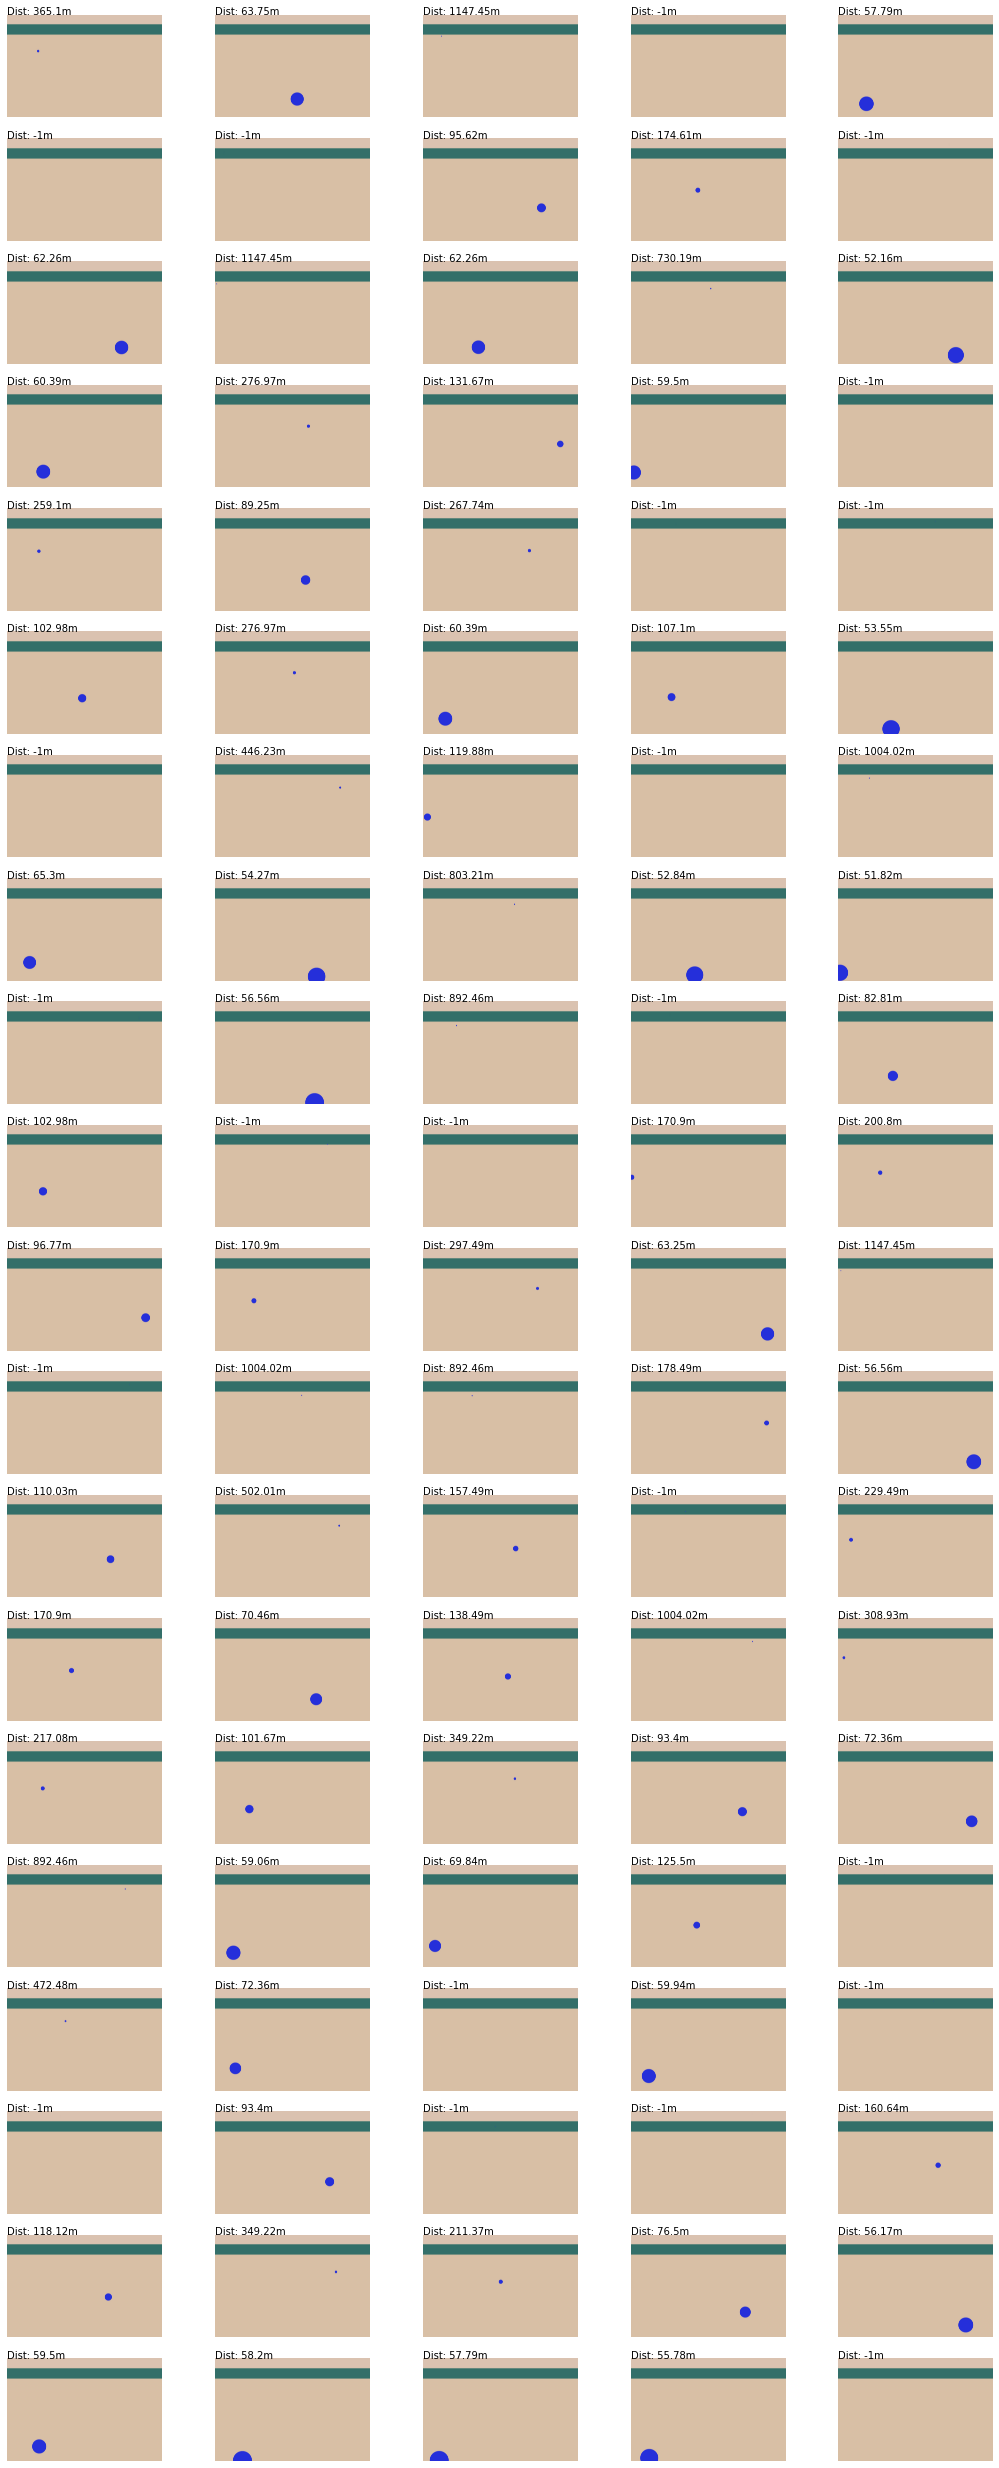

In [487]:
n_row = 20
n_col = 5

# inspired by https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
_, axs = plt.subplots(n_row, n_col, figsize=(18, 45))
axs = axs.flatten()
for i, (img, ax) in enumerate(zip(images, axs)):
    ax.imshow(img)
    ax.annotate("Dist: " + str(buoy_distances_in_meters[i]) + "m", xy=(0, 1), xycoords="axes fraction")
    ax.axis('off')
plt.show()